##### Assignment 1 - Simplified Custom Object Detection

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of object detection: -from `loading and inspecting the dataset`; -to `implementing`, `training and evaluating a Convolutional Neural Network based architecture`. The sections are there to guide you but you do not have to follow them strictly.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you are using this in Google Colab notebook, save it as .ipynb and upload it, or share the public link. If you have your own machine with Jupyter installed, you can work there as well, as long as you save and upload the .ipynb file.


## General Rules
Please check all the requirements listed on Canvas, but here are some general rules:
- Please select at least ANY 3 objects of choice. Try to pick unique objects. You may pick more, but less than 3 is not acceptable and results in losing points;
- While we do not require a high performance model, we still expect you to have a model that performs better than "random guessing" (i.e. for 3 objects, mAP should be better than 33%);
- Copying others' code will make you fail the assignment automatically, resulting in a 0;
- Not submitting anything results in a 0;
- Submitting something, as long as it is not an empty notebook, might result in a 1;
- **Deadline is October 25th Friday 11:59 PM** (strict, no late submission)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name:** Eliyas Kidanemariam Abraha  

**Neptun ID:** P6013D

**Network:**  Custome Model - 5 convoultional layer(including max pol for each , batch normalization , drope out , relu activation function), 1 shared fully connected layer , 2 fully connected layer(one for classification and one for bbox regration)

**Objects:** car , bicycle , traffic-cross-sign (which are commonly used in autonmous car)

## Task description

**Your task** is to train your own custom object detection model and compare its performance with an existing object detection model (i.e., YOLO). For that, you need to generate a synthetic dataset to train your own custom model and fine-tune an existing one. This is a simplified version of object detection, where each image must only contain a single object.

- There is no expectation of high performance, but **your metrics should show results better than random guessing, and your loss must decrease throughout the epochs**.

- We expect you to visualize the key metrics such as precision, recall, F1-score, mAP (mean average precision), IoU (Intersection over Union), and localization loss, in addition to monitoring the overall loss and its reduction across training. Use plots and visualizations (e.g., matplotlib, seaborn) to display metrics, losses, and predictions.

- You should implement techniques to avoid overfitting, such as Early Stopping, and save the best-performing model during training.

- Additionally, you can use **WandB (Weights and Biases)** or **TensorBoard** to track and visualize training progress, monitor the model's performance, and log metrics over time.

`Good luck!`

**In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.**

## Guidelines
Please carefully read each cell of the notebook, as they contain guidelines to help you complete the assignments. While you don't have to follow them strictly, we believe that they provide enough help.

# 0. Necessary Imports
Import all the necessary packages for this assignment. **ONLY PYTORCH MODELS ARE ACCEPTED!**

In [2]:
# ADD YOUR CODE HERE
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import cv2  # OpenCV
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torchvision.models as models
from torchinfo import summary
from tqdm import tqdm
from torch.cuda import amp
import wandb
from multiprocessing import cpu_count


# 1. DATASET
**For this assignment you are free to pick any 3 objects of your choice.** Please avoid offensive, inappropriate or violent objects.

### 1.1. Load objects

**Please select 3 or more objects.** After selecting the objects, **remove the background, keeping only the object itself**. You can do this manually, online, or by using code (this step is not part of the assignment evaluation).

As an example, the following objects were chosen (with the background removed using the Segment Anything Model):

In [4]:
# ADD YOUR CODE HERE
# !unzip -q "$root_dir""/objects.zip"
# !unzip -q "$root_dir""/background.zip"
!unzip -q "$root_dir""/dataset.zip"

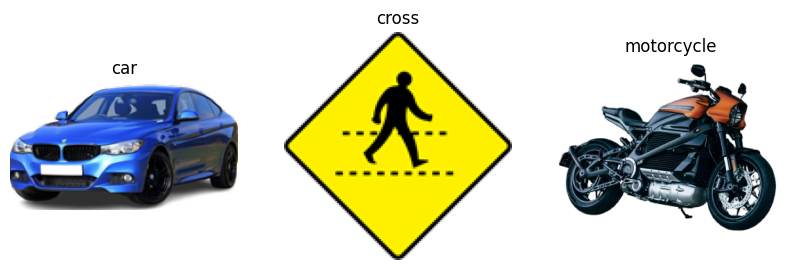

In [2]:
object_dir = 'objects/'
background_dir = 'background/'
dataset_dir = 'dataset/'
object_class = ['car' , 'cross' , 'motorcycle']
fig , axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 15))
for i,image_name in enumerate(object_class):
    image = os.path.join(object_dir, image_name + '.png')
    img = Image.open(image)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(image_name)
plt.show()

### 1.2. Load backgrounds

In order to train a custom object detection model, a dataset is needed. For this assignment, a synthetic dataset should be created by:

- **Inserting an object in a random position** on a background image.

**Therefore, collect a few background images from different locations** This can be done manually or via code.

It is recommended to use **icrawler** to automate the image collection process.


In [ ]:
!pip install icrawler

In [ ]:
!mkdir background

In case of any errors, try using a different crawler. You can use one of the following options:

```python
from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler


In [ ]:
from icrawler.builtin import GoogleImageCrawler

google_crawler = GoogleImageCrawler(
    parser_threads=2,
    downloader_threads=4,
    storage={'root_dir': 'background'}
)

background_keywords = [
    # Natural Landscapes
    'forest', 'mountain range', 'grassland', 'canyon', 'valley', 'snow-covered hills',
    'tropical island', 'coastal cliffs', 'rocky terrain', 'meadow', 'pine forest',

]

# add good back ground keywords tha does not make occlision with the object

# for keyword in ['budapest','paris' ,'girona','rio de janeiro','Amazon River','london','tower','roma','budapest parliament', 'buda castle', 'budapest st stephen basilica', 'budapest heroes square']:
for keyword in background_keywords:
    google_crawler.crawl(
        keyword=keyword, max_num=10, file_idx_offset='auto') #, min_size=(500, 500),)

#Some images may return an error, but icrawler tries to find other images regardless

2121


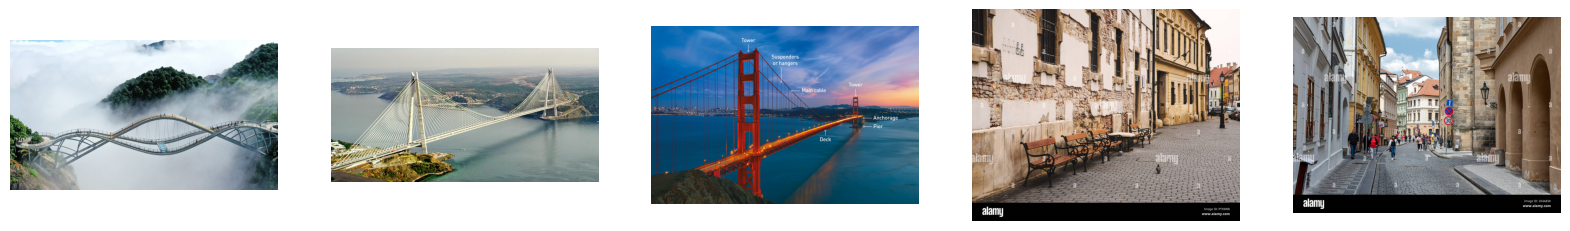

In [196]:
directory = 'background'
object_class = ['stop' , 'two_way' , 'cross']
# Show some of the images, to confirm that they were successfully crawled
def display_sample_images(directory):
    number_of__sample_images = 5
    random = np.random.randint(0, len(os.listdir(directory)) - number_of__sample_images)
    print(random)
    col = 5
    fig , axes = plt.subplots(nrows=1, ncols=col, figsize=(20, 20))
    images = os.listdir(directory)[random:random+5]
    for i , image in enumerate(images):
        img = plt.imread(os.path.join(directory, image))
        axes[i].imshow(img)
        axes[i].axis('off')

display_sample_images(directory)

### 1.3. Create dataset

### Dataset Creation

This is a crucial part of the assignment evaluation. From the selected objects and collected background images, follow these steps to generate your dataset:

1. **Randomly select background images** from your collection.
2. **Insert a single object** (from the three selected) into each background image at a **random location**.
3. **Record the object's coordinates** and create a corresponding bounding box. For example:
   - If an object with height `h` and width `w` is placed at position `(x, y)`, the bounding box should be in one of the following formats:
     - **[x, y, w, h]** or
     - **[x1, y1, x2, y2]**, where `x2 = x1 + w` and `y2 = y1 + h`.
4. If you plan to compare your custom model with a YOLO model, use the **YOLO bounding box format**:
   - `[(x + w/2)/image_width, (y + h/2)/image_height, w/image_width, h/image_height]`, where `image` refers to the background image dimensions.
5. **Save the generated dataset**, as it will be used for training your custom model and fine-tuning the existing object detection model.
6. **Wrap the dataset creation** in a **PyTorch Dataset class** for easier data handling and model training.
7. **Split the dataset** into training, validation, and test sets to evaluate your model effectively.


In [17]:
object_dir = 'objects'
background_dir = 'back'

def createDataset(root_dir, dataset_name, split, img_size, num_images):

    os.makedirs(f'{root_dir}/{split}/images', exist_ok=True)
    os.makedirs(f'{root_dir}/{split}/labels', exist_ok=True)

    count = 0

    while count < num_images:
        # select random background
        background_ind= np.random.choice(os.listdir(background_dir))
        background_image = Image.open(os.path.join(background_dir, background_ind)).convert('RGB')

        # select object based on the count index module of 3
        object_ind = count % 3

        object = os.path.join(object_dir, f'{object_class[object_ind]}.png')
        object_image = Image.open(object)
        object_size = object_image.size
        background_size = background_image.size
       
       
        try:
            if  object_size[0] > img_size[0] or object_size[1] > img_size[1]:
                continue
            elif(background_size[0] < img_size[0] or background_size[1] < img_size[1]  ):
                continue
            else:
                background_image = background_image.resize(img_size)
                min_x , min_y = 0 , 0 
                max_x , max_y = int(img_size[0] - object_size[0]) ,int(img_size[1] - object_size[1])
                insert_pose = (np.random.randint(0, max_x), np.random.randint(0, max_y))
                
                image = background_image.copy()
                image.paste(object_image, insert_pose, object_image)
                # get the insert pose in the resized image
                image.save(f'{root_dir}/{split}/images/{count}.png')
                x_center = (insert_pose[0] + object_size[0] / 2) / img_size[0]
                y_center = (insert_pose[1] + object_size[1] / 2) / img_size[1]
                width  = object_size[0] / img_size[0]
                height = object_size[1] / img_size[1]
                
                with open(f'{root_dir}/{split}/labels/{count}.txt', 'w') as f:
                    f.write(f'{object_ind} {x_center} {y_center} {width} {height}')
                count += 1
        except:
            continue
    pass

createDataset('datasets', 'background', split='train', img_size=(320,320), num_images=5000)
createDataset('datasets', 'background', split='val', img_size=(320,320), num_images=1000)
createDataset('datasets', 'background', split='test', img_size=(320,320), num_images=200)

In [8]:
# ADD YOUR CODE HERE

class ObjectDetectionDataset(Dataset):
    def __init__(self, root_dir, split='train', num_classes=3, transform=None):
        self.root_dir = root_dir
        self.split_dir = os.path.join(root_dir, split)
        self.image_dir = os.path.join(self.split_dir, 'images')
        self.label_dir = os.path.join(self.split_dir, 'labels')
        self.image_filenames = sorted(os.listdir(self.image_dir))
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        try:
            image_path = os.path.join(self.image_dir, self.image_filenames[idx])
            label_path = os.path.join(self.label_dir, self.image_filenames[idx].replace('.png', '.txt'))

            with open(label_path, 'r') as f:
                label = f.readline().split()
            category = int(label[0])
            bbox = [float(l) for l in label[1:]]
            image = Image.open(image_path).convert('RGB')
            with open(label_path, 'r') as f:
                label = f.readline().split()
            label = [int(label[0])] + [float(l) for l in label[1:]]
            if self.transform:
                image = self.transform(image)


            return image, torch.tensor(category), torch.tensor(bbox) #generous hint
        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            raise


In [9]:
root_dir = 'datasets'

# calculated mean,std of the image in separate program
tran_mean = [0.4715, 0.4941, 0.4945] # not used 
train_std = [0.2415, 0.2212, 0.2428] # not used

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((320, 320)),
])

train_dataset = ObjectDetectionDataset(root_dir, split='train', transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True )

val_dataset   = ObjectDetectionDataset(root_dir, split='val', transform=transform)
val_loader    = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)


test_dataset  = ObjectDetectionDataset(root_dir, split='test', transform=transform)
test_loader   = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True )



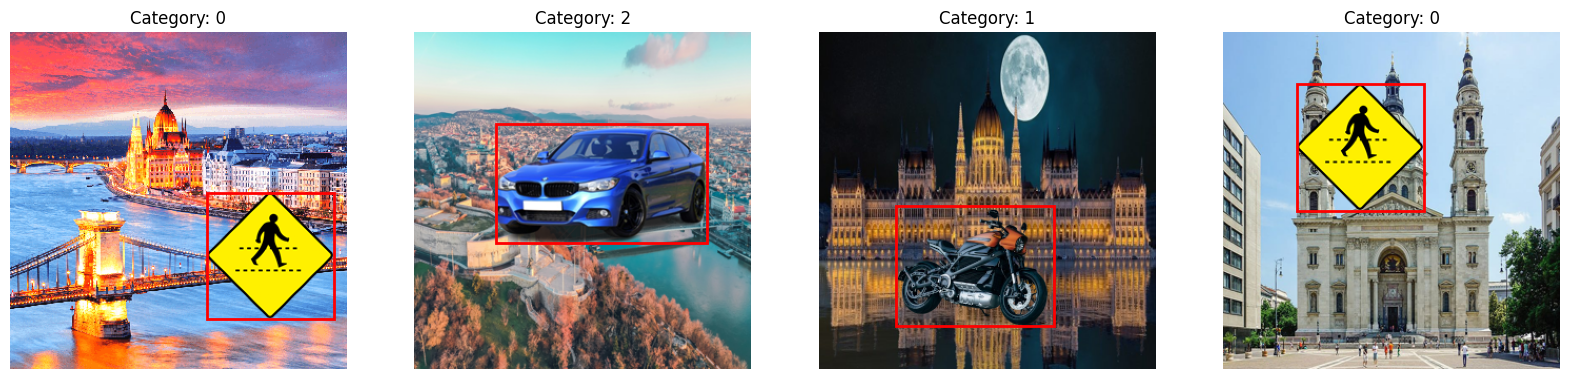

In [8]:
# Show some visualizations of the created dataset
import matplotlib.patches as patches
def visualize_dataset(dataset):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 20))

    for i, ax in enumerate(axes.flatten()):
        index = np.random.randint(0, len(dataset))
        image, category, bbox = dataset.__getitem__(index)
        image = image.permute(1, 2, 0).numpy()
        # width and height are the last two elements of bbox
        x_center, y_center, width, height = bbox
        # change the x_center, y_center, width, height to the original image size
        x_center = x_center * image.shape[0]
        y_center = y_center * image.shape[1]
        width = width * image.shape[0]
        height = height * image.shape[1]
         # Create a rectangle patch
        rect = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.imshow(image)
        ax.add_patch(rect)
        ax.axis('off')
        ax.set_title(f'Category: {category.item()}')
    plt.show()

visualize_dataset(train_dataset)

### 2. MODELS

In this assignment, you are tasked with building your own custom object detection model and comparing its performance against an existing object detection model.


### 2.1. Custom Object Detection model

### Create a Convolutional Neural Network (CNN) Architecture

Design a CNN-based architecture that includes a **backbone for feature extraction** and two output branches:

- One for **class probabilities** (with output size equal to the number of object classes, e.g., 3).
- Another for **bounding box regression** (with size 4 for the box coordinates: x, y, w, h, or in your chosen format).



This is the core evaluation of the assignment. Experiment with different layers, hyperparameters, and regularization techniques to optimize the model's performance.


In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
import torch
print(torch.cuda.is_available())

False


In [5]:

class CustomObjectDetectionModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomObjectDetectionModel, self).__init__()
        # Backbone: Feature Extraction
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 80 X 80
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 40X40
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 20 X 20
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 10X10
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(p=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully Connected Layers (shared)
        self.shared_fc = nn.Sequential(
            nn.Linear(256 * 10 * 10, 512),  # Adjusted input size
            nn.Linear(512 , 1024),  # Adjusted input size
        )
        # Classification
        self.cllasification = nn.Sequential(
            nn.Linear(1024, num_classes)
        )

        # Bounding Box Regression
        self.bbox_regression = nn.Sequential(
            nn.Linear(1024, 4)
        )

    def forward(self, x):
        # Feature extraction
        x = self.backbone(x)
        x = x.view(x.size(0), -1)  # Flattening the feature map
        x = self.shared_fc(x)
        # Class Prediction Branch
        cllasification_out = self.cllasification(x)  # Softmax for class probabilities
        # Bounding Box Regression Branch
        bbox_out = self.bbox_regression(x)  # No activation (linear output)

        return cllasification_out, bbox_out


## Network Summery 
1. network architecture summery - 5 conv layer , 1 shared fc layer , fc layer for each 
2. number of parametrs to learn - 14,620,167
3. total wieght of the network  - 259.49 MB

In [6]:

from torchsummary import summary
dummy_image = torch.randn(1, 3, 320, 320).to(device)
num_classes = 3
model = CustomObjectDetectionModel(num_classes).to(device)
# torch.cuda.empty_cache()
cls_output, bbox_output = model(dummy_image)

summary(model, input_size=( 3, 320, 320) )


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 320]             896
       BatchNorm2d-2         [-1, 32, 320, 320]              64
              ReLU-3         [-1, 32, 320, 320]               0
         Dropout2d-4         [-1, 32, 320, 320]               0
         MaxPool2d-5         [-1, 32, 160, 160]               0
            Conv2d-6         [-1, 64, 160, 160]          18,496
       BatchNorm2d-7         [-1, 64, 160, 160]             128
              ReLU-8         [-1, 64, 160, 160]               0
         Dropout2d-9         [-1, 64, 160, 160]               0
        MaxPool2d-10           [-1, 64, 80, 80]               0
           Conv2d-11          [-1, 128, 80, 80]          73,856
      BatchNorm2d-12          [-1, 128, 80, 80]             256
             ReLU-13          [-1, 128, 80, 80]               0
        Dropout2d-14          [-1, 128,

## Basic Configuration:  
this is wanb configuration we can set different hayper parametra for different experiment 
    
hyperparameters used:

    - lr: Learning rate, which controls the step size during gradient descent.
    - wt: Weight decay, a regularization term to prevent overfitting by penalizing large weights.
    - step: Step size, the number of epochs after which the learning rate is reduced.
    - gamma: Multiplicative factor for learning rate decay, used to reduce the learning rate.
    - epochs: Number of epochs, the total number of times the training loop will iterate over the entire dataset.

In [6]:
wandb_args = dict(
    api_key = '5a3ea9fc5548d6fd064befd6c191547ee68288ba', # Your API Key (access from settings)
    entity = 'eliyas_kidane',  # Your W&B username
    project = 'Object-Detection-Project'  # Your project name on W&B
)

#################################################
# Tune the hyperparameters here
# You need not tweak/set all the hyperparameters
config = dict(
    lr = 0.00001, wt = 0.002,
    step = 10, gamma = 0.1,
    epochs = 30,
)
#################################################

os.environ['WANDB_API_KEY'] = wandb_args['api_key']
wandb_logger = wandb.init(
    entity=wandb_args['entity'], project=wandb_args['project'],
    config=config, resume=True,
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
threads = cpu_count()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eliyaskidane (eliyas_kidane). Use `wandb login --relogin` to force relogin


### 2.2. Train Your Model

Carefully choose key components like the **optimizer**, **loss function**, **number of epochs**, and **regularization techniques**. Ensure you're optimizing both **classification loss** and **bounding box regression loss**.

Monitor for signs of **overfitting** or **underfitting** by tracking how the loss evolves across epochs. The loss should consistently decrease as training progresses. Save and log these losses for visualization and further analysis.


**Example Plot**:

<a href="https://ibb.co/bzmMxJY"><img src="https://i.ibb.co/t8KTSXn/download.png" alt="download" border="0"></a>

In [30]:
def save_checkpoint(scheduler, optimizer, model, loss_history, epoch, filename):
    checkpoint_dict = {
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
        'loss_history': loss_history,
        'epoch': epoch
    }
    torch.save(checkpoint_dict, filename)


def load_checkpoint(scheduler, optimizer, model, filename):
    print(f"Loading checkpoint from {device}")
    checkpoint_dict = torch.load(filename , map_location=device)
    model.load_state_dict(checkpoint_dict['model'] , map_location=device)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint_dict['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint_dict['scheduler'])
    return checkpoint_dict['epoch'], checkpoint_dict['loss_history']

In [194]:
# define trian step
from tqdm import tqdm


def train_step(model, train_loader,classification_criterion, bbox_criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    train_acc = 0
    total = 0
    train_class_loss = 0
    train_bbox_loss = 0

    for i, (images, categorys , bbox) in enumerate(train_loader):
        images = images.to(device)
        categorys = categorys.to(device)
        bbox = bbox.to(device)
        optimizer.zero_grad()
        class_outputs, bbox_outputs  = model(images)
        classf_loss = classification_criterion(class_outputs, categorys)
        bbox_loss = bbox_criterion(bbox_outputs, bbox)
        loss = classf_loss + 2*bbox_loss
         # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        loss.backward()
        optimizer.step()
        output_class = torch.argmax(torch.softmax(class_outputs, dim=1), dim=1)
        train_class_loss += classf_loss.item()
        train_bbox_loss += bbox_loss.item()
    del images , classf_loss , bbox_loss , loss
    length = len(train_loader)
    
    return train_class_loss/length ,train_bbox_loss/length
def val_step(model, val_loader, classification_criterion, bbox_criterion , device):
    model.eval()
    val_loss = 0.0
    val_acc = 0
    val_class_loss = 0
    val_bbox_loss = 0
    total = 0

    with torch.no_grad():
        for i, (images, categorys , bbox) in enumerate(val_loader):
            images = images.to(device)
            categorys =  categorys.to(device)
            bbox = bbox.to(device)
            class_outputs, bbox_outputs  = model(images)
            classf_loss = classification_criterion(class_outputs, categorys)
            bbox_loss = bbox_criterion(bbox_outputs, bbox)
            loss = classf_loss + bbox_loss
            output_class = torch.argmax(torch.softmax(class_outputs, dim=1), dim=1)
            val_class_loss += classf_loss.item()*40
            val_bbox_loss += bbox_loss.item()*40

    length = len(val_loader)
    del images , classf_loss , bbox_loss , loss
    return val_class_loss / length , val_bbox_loss/length
    
    
# Train the model

def train_model( model,train_loader,val_loader,classification_criterion, bbox_criterion,optimizer,scheduler , device,epochs = 10,
                 logging=False, checkpointing=False, resume_from_checkpoint=None):
    

    train_history = {
        # "train_loss": [],
        # "train_acc": [],
        "train_class_loss": [],
        "train_bbox_loss": [],
        # "val_loss": [],
        # "val_acc": [],
        "val_class_loss": [],
        "val_bbox_loss": [],
    }

    if resume_from_checkpoint:
        try:
            start, train_history = load_checkpoint(scheduler, optimizer, model, resume_from_checkpoint)
        except FileNotFoundError:
            print('Checkpoint not found! Training from scratch...\n')
        except:
            print('Error loading checkpoint! Training from scratch...\n')

    if checkpointing:
        checkpoint_dir = 'checkpoints/obj_det/'
        print('Saving checkpoints in: '+checkpoint_dir)
        os.makedirs(checkpoint_dir, exist_ok=True)
        print('Saving checkpoints in: '+checkpoint_dir)

    if logging:
        logs_dir = 'logs/obj_det/'
        os.makedirs(logs_dir, exist_ok=True)
        log_file_path = logs_dir+'obj_det-xxx-log.txt'
        log_file = open(log_file_path, 'w')
        print('Logging to: '+log_file_path)


    for epoch in tqdm(range(epochs)):
        train_class_loss,train_bbox_loss = train_step(model, train_loader,classification_criterion, bbox_criterion, optimizer, device)
       
        val_class_loss ,val_bbox_loss = val_step(model, val_loader,classification_criterion, bbox_criterion, device)
        # scheduler.step(val_class_loss + val_bbox_loss)
        scheduler.step()
        train_history["train_class_loss"].append(train_class_loss)
        train_history["train_bbox_loss"].append(train_bbox_loss)
        train_history["val_class_loss"].append(val_class_loss)
        train_history["val_bbox_loss"].append(val_bbox_loss)

        if logging:
            print('\nEpoch {}/{}'.format(epoch+1, epochs), file=log_file)
            print('-' * 10, file=log_file)
            print(f"Train C_Loss: {train_class_loss:.4f},:train_bbox_loss :{train_bbox_loss:.2f},\
                  \n  val_class_loss: {val_class_loss:.4f},val_bbox_loss: {val_bbox_loss:.2f}", file=log_file)

        # print(f"Epoch: {epoch+1}/{epochs}, \n Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.2f}%")
        print(f"Epoch: {epoch+1}/{epochs}, \n Train C_Loss: {train_class_loss:.5f},:train_bbox_loss :{train_bbox_loss:.5f},\n  val_class_loss: {val_class_loss:.5f},val_bbox_loss: {val_bbox_loss:.5f}")
        
         # save checkpoint
        if checkpointing:
            checkpoint_filename = checkpoint_dir+'obj_detNet-cp{:03d}.pkl'.format(epoch)
            save_checkpoint(scheduler, optimizer, model, train_history, epoch, checkpoint_filename)
            if epoch > 2:
                prev_checkpoint = 'obj_detNet-cp{:03d}.pkl'.format(epoch-2)
                os.remove(checkpoint_dir+prev_checkpoint)

        wandb_logger.log({
                'train_class_loss': train_class_loss,
                'train_bbox_loss': train_bbox_loss,
                'val_class_loss': val_class_loss,
                'val_bbox_loss': val_bbox_loss,
                
        },step=epoch)

        # torch.cuda.empty_cache()

    wandb_logger.finish()
    return model , train_history


def plot_result(result):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)

    plt.plot(result["train_class_loss"], label="train_class_loss")
    plt.plot(result["val_class_loss"], label="val_class_loss")
    plt.plot(result["train_bbox_loss"], label="train_bbox_loss")
    plt.plot(result["val_bbox_loss"], label="val_bbox_loss")
    plt.title("Loss")
    plt.legend()


Saving checkpoints in: checkpoints/obj_det/
Saving checkpoints in: checkpoints/obj_det/
Logging to: logs/obj_det/obj_det-xxx-log.txt


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1/30, 
 Train C_Loss: 16.95758,:train_bbox_loss :0.30655,
  val_class_loss: 5.74314,val_bbox_loss: 0.12514


  3%|▎         | 1/30 [01:08<33:01, 68.34s/it]

Epoch: 2/30, 
 Train C_Loss: 5.09866,:train_bbox_loss :0.15266,
  val_class_loss: 1.21558,val_bbox_loss: 0.15877


  7%|▋         | 2/30 [02:13<31:06, 66.65s/it]

Epoch: 3/30, 
 Train C_Loss: 2.24909,:train_bbox_loss :0.10898,
  val_class_loss: 0.62735,val_bbox_loss: 0.11950


 10%|█         | 3/30 [03:28<31:35, 70.22s/it]

Epoch: 4/30, 
 Train C_Loss: 1.23221,:train_bbox_loss :0.08879,
  val_class_loss: 0.27423,val_bbox_loss: 0.09923


 13%|█▎        | 4/30 [04:32<29:27, 67.99s/it]

Epoch: 5/30, 
 Train C_Loss: 0.93173,:train_bbox_loss :0.07606,
  val_class_loss: 0.44387,val_bbox_loss: 0.07153


 17%|█▋        | 5/30 [05:42<28:32, 68.52s/it]

Epoch: 6/30, 
 Train C_Loss: 0.52024,:train_bbox_loss :0.06670,
  val_class_loss: 0.13819,val_bbox_loss: 0.05429


 20%|██        | 6/30 [06:50<27:21, 68.41s/it]

Epoch: 7/30, 
 Train C_Loss: 0.65596,:train_bbox_loss :0.06108,
  val_class_loss: 0.02226,val_bbox_loss: 0.05525


 23%|██▎       | 7/30 [08:08<27:23, 71.45s/it]

Epoch: 8/30, 
 Train C_Loss: 0.56787,:train_bbox_loss :0.05227,
  val_class_loss: 0.46405,val_bbox_loss: 0.05078


 27%|██▋       | 8/30 [09:19<26:07, 71.25s/it]

Epoch: 9/30, 
 Train C_Loss: 0.43836,:train_bbox_loss :0.04844,
  val_class_loss: 0.14674,val_bbox_loss: 0.04229


 30%|███       | 9/30 [10:36<25:39, 73.31s/it]

Epoch: 10/30, 
 Train C_Loss: 0.43612,:train_bbox_loss :0.04704,
  val_class_loss: 0.04196,val_bbox_loss: 0.05180


 33%|███▎      | 10/30 [11:48<24:16, 72.83s/it]

Epoch: 11/30, 
 Train C_Loss: 0.11687,:train_bbox_loss :0.03245,
  val_class_loss: 0.01910,val_bbox_loss: 0.03139


 37%|███▋      | 11/30 [12:54<22:23, 70.70s/it]

Epoch: 12/30, 
 Train C_Loss: 0.11080,:train_bbox_loss :0.03117,
  val_class_loss: 0.01456,val_bbox_loss: 0.02569


 40%|████      | 12/30 [13:54<20:15, 67.51s/it]

Epoch: 13/30, 
 Train C_Loss: 0.07695,:train_bbox_loss :0.03009,
  val_class_loss: 0.02698,val_bbox_loss: 0.02413


 43%|████▎     | 13/30 [15:02<19:10, 67.70s/it]

Epoch: 14/30, 
 Train C_Loss: 0.11616,:train_bbox_loss :0.03017,
  val_class_loss: 0.01764,val_bbox_loss: 0.03192


 47%|████▋     | 14/30 [16:06<17:45, 66.58s/it]

Epoch: 15/30, 
 Train C_Loss: 0.21570,:train_bbox_loss :0.02992,
  val_class_loss: 0.02160,val_bbox_loss: 0.02628


 50%|█████     | 15/30 [17:24<17:30, 70.02s/it]

Epoch: 16/30, 
 Train C_Loss: 0.07590,:train_bbox_loss :0.02928,
  val_class_loss: 0.02185,val_bbox_loss: 0.02795


 53%|█████▎    | 16/30 [18:42<16:52, 72.35s/it]

Epoch: 17/30, 
 Train C_Loss: 0.13586,:train_bbox_loss :0.02962,
  val_class_loss: 0.02739,val_bbox_loss: 0.03228


 57%|█████▋    | 17/30 [19:46<15:05, 69.66s/it]

Epoch: 18/30, 
 Train C_Loss: 0.07313,:train_bbox_loss :0.02904,
  val_class_loss: 0.01229,val_bbox_loss: 0.02666


 60%|██████    | 18/30 [20:45<13:19, 66.60s/it]

Epoch: 19/30, 
 Train C_Loss: 0.12199,:train_bbox_loss :0.02849,
  val_class_loss: 0.01416,val_bbox_loss: 0.02404


 63%|██████▎   | 19/30 [21:51<12:10, 66.41s/it]

Epoch: 20/30, 
 Train C_Loss: 0.08019,:train_bbox_loss :0.02825,
  val_class_loss: 0.03472,val_bbox_loss: 0.02588


 67%|██████▋   | 20/30 [23:06<11:28, 68.89s/it]

Epoch: 21/30, 
 Train C_Loss: 0.06603,:train_bbox_loss :0.02796,
  val_class_loss: 0.04282,val_bbox_loss: 0.02568


 70%|███████   | 21/30 [24:24<10:45, 71.75s/it]

Epoch: 22/30, 
 Train C_Loss: 0.04959,:train_bbox_loss :0.02623,
  val_class_loss: 0.03839,val_bbox_loss: 0.02633


 73%|███████▎  | 22/30 [25:43<09:50, 73.79s/it]

Epoch: 23/30, 
 Train C_Loss: 0.05619,:train_bbox_loss :0.02650,
  val_class_loss: 0.02353,val_bbox_loss: 0.02703


 77%|███████▋  | 23/30 [27:01<08:45, 75.05s/it]

Epoch: 24/30, 
 Train C_Loss: 0.07093,:train_bbox_loss :0.02681,
  val_class_loss: 0.01741,val_bbox_loss: 0.02526


 80%|████████  | 24/30 [28:18<07:35, 75.90s/it]

Epoch: 25/30, 
 Train C_Loss: 0.06807,:train_bbox_loss :0.02648,
  val_class_loss: 0.01696,val_bbox_loss: 0.02919


 83%|████████▎ | 25/30 [29:35<06:20, 76.04s/it]

Epoch: 26/30, 
 Train C_Loss: 0.05270,:train_bbox_loss :0.02643,
  val_class_loss: 0.02681,val_bbox_loss: 0.02520


 87%|████████▋ | 26/30 [30:53<05:06, 76.68s/it]

Epoch: 27/30, 
 Train C_Loss: 0.06381,:train_bbox_loss :0.02616,
  val_class_loss: 0.03046,val_bbox_loss: 0.02604


 90%|█████████ | 27/30 [32:11<03:50, 76.97s/it]

Epoch: 28/30, 
 Train C_Loss: 0.06848,:train_bbox_loss :0.02710,
  val_class_loss: 0.01945,val_bbox_loss: 0.02131


 93%|█████████▎| 28/30 [33:28<02:34, 77.15s/it]

Epoch: 29/30, 
 Train C_Loss: 0.04474,:train_bbox_loss :0.02616,
  val_class_loss: 0.01541,val_bbox_loss: 0.02216


 97%|█████████▋| 29/30 [34:37<01:14, 74.61s/it]

Epoch: 30/30, 
 Train C_Loss: 0.04540,:train_bbox_loss :0.02612,
  val_class_loss: 0.01625,val_bbox_loss: 0.02614


100%|██████████| 30/30 [35:37<00:00, 71.27s/it]


train_bbox_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_class_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_bbox_loss,▆█▆▅▄▃▃▃▂▃▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_class_loss,█▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_bbox_loss,0.02612
train_class_loss,0.0454
val_bbox_loss,0.02614
val_class_loss,0.01625


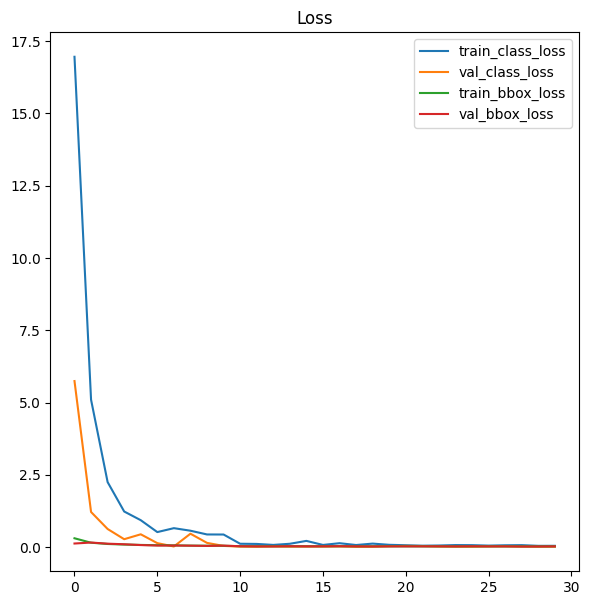

In [195]:
import torch
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['wt'])
scheduler = StepLR(optimizer, step_size=config['step'], gamma=config['gamma'])
class_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()

# Train the model
epochs = 30
model, train_history = train_model(model, train_loader, val_loader, class_loss_fn, bbox_loss_fn, optimizer, 
                                   scheduler, device, epochs, logging=True, checkpointing=True)

# Plot results
plot_result(train_history)

### 2.3. Evaulate and do inference with the trained custom model

precision, recall, mAP = evaluate_test_set(trained_model, test_loader, device)
print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, mAP: {mAP:.4f}')Choose **at least 3 metrics** to evaluate your object detection model. These could include:

- **Precision**: The proportion of correctly predicted positive instances (objects detected) out of all instances classified as positive.
- **Recall**: The proportion of correctly predicted positive instances out of all actual positive instances (objects present in the image).
- **F1-Score**: The harmonic mean of Precision and Recall, balancing false positives and false negatives.
- **IoU (Intersection over Union)**: Measures the overlap between the predicted bounding box and the ground truth bounding box.
- **mAP (mean Average Precision)**: This is one of the most common evaluation metrics for object detection. It averages precision at different recall thresholds across all object classes.
  
Additionally, you can assess:
- **Inference speed**: Time taken by the model to process a single image.
- **Number of parameters**: The total number of trainable parameters in the model.
- **Model size**: The disk size of the trained model.

### Show Performance Metric Visualizations

- Visualize the chosen metrics (e.g., **Precision, Recall, F1-Score, IoU, mAP**) over different epochs to demonstrate the improvement in the model’s performance.
- Plot losses (both classification loss and localization loss) to show how they decrease throughout training.

### Show Some Predictions of Your Trained Model

- Display sample images with **predicted bounding boxes** and compare them to the ground truth.
- Highlight the values of **Precision, Recall, IoU**, or other relevant metrics for each displayed prediction, giving a clear view of the model's performance.
  
You can also use **WandB (Weights and Biases)** or **TensorBoard** for more detailed logging and tracking of these metrics and visualizations.


In [31]:

from sklearn.metrics import precision_score, recall_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# load model
num_classes = 3
model = CustomObjectDetectionModel(num_classes).to(device)
# checkpoint = torch.load('checkpoints\obj_det\obj_detNet-cp029_finall.pkl')
checkpoint = torch.load('checkpoints/obj_det/obj_detNet-cp029_finall.pkl' , map_location=device)
model.load_state_dict(checkpoint['model'])

def caculate_iou(bbox1, bbox2):

    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2

    x1_min, y1_min, x1_max, y1_max = x1 - w1 / 2, y1 - h1 / 2, x1 + w1 / 2, y1 + h1 / 2
    x2_min, y2_min, x2_max, y2_max = x2 - w2 / 2, y2 - h2 / 2, x2 + w2 / 2, y2 + h2 / 2

    xA = max(x1_min, x2_min)
    yA = max(y1_min, y2_min)
    xB = min(x1_max, x2_max)
    yB = min(y1_max, y2_max)

    interArea = max(0, xB - xA) * max(0, yB - yA)

    box1Area = w1 * h1
    box2Area = w2 * h2

    iou = interArea / float(box1Area + box2Area - interArea)
    return iou


from torchvision.ops import box_iou
import torch.nn.functional as F
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def evaluate_test_set(model, test_loader, device, iou_threshold=0.5):
    model.eval()
    preds = []
    targets = []
    
    with torch.no_grad():
        for images, categories, bboxes in test_loader:
            images, categories, bboxes = images.to(device), categories.to(device), bboxes.to(device)
            class_probs, bbox_preds = model(images)
            class_probs = F.softmax(class_probs, dim=1) 
            pred_scores, pred_labels = torch.max(class_probs, 1)
            preds.extend(
                [dict(

                boxes=bbox_preds[i].unsqueeze(0),
                scores=pred_scores[i].unsqueeze(0),  
                labels=pred_labels[i].unsqueeze(0)   

            ) for i in range(len(categories))]
            )

            targets.extend([dict(
                boxes=bboxes[i].unsqueeze(0),
                labels=categories[i].unsqueeze(0)
            ) for i in range(len(categories))])
            break

    # Calculate metrics (Precision, Recall, mAP)
    metric = MeanAveragePrecision(iou_type="bbox", box_format='cxcywh')
  
    metric.update(preds, targets)

    return metric.compute()['map_50'].item(), metric.compute()['map_75'].item(), metric.compute()['map'].item()


custome_map_50  ,custome_map_75 , custome_map = evaluate_test_set(model, test_loader, device)
print("--------custom model mAP at different IoU thresholds--------")
print("map_50 : ", custome_map_50)
print("map_75 : ", custome_map_75)
print("maP : ", custome_map)




--------custom model mAP at different IoU thresholds--------
map_50 :  0.8349835276603699
map_75 :  0.3685368597507477
maP :  0.3982398211956024


In [ ]:

object_class = ['cross' , 'motor' , 'car']

import matplotlib.patches as patches
def visualize_predictions(model, test_dataset):

    model.eval()
    model.to(device)
    with torch.no_grad():
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12))
        for i, ax in enumerate(axes.flatten()):
            rand = np.random.randint(0, len(test_dataset))
            image, category, bbox = test_dataset[rand]
            image , category , bbox  = image.unsqueeze(0).to(device) , category.unsqueeze(0).to(device) , bbox.unsqueeze(0).to(device)
            class_output, bbox_output = model(image)
            _, predicted = torch.max(class_output.data , 1)
            predicted = predicted.item()
            bbox_output = bbox_output.cpu().numpy().squeeze()
            bbox = bbox.cpu().numpy().squeeze()
            image = image.cpu().squeeze().permute(1, 2, 0).numpy()
            iou = caculate_iou(bbox, bbox_output)
            image = np.ascontiguousarray(image)
            # width and height are the last two elements of bbox
            x_center, y_center, width, height = bbox
            # change the x_center, y_center, width, height to the original image size
            x_center = x_center * image.shape[0]
            y_center = y_center * image.shape[1]
            width = width * image.shape[0]
            height = height * image.shape[1]
            
            rectangle1 = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='r', facecolor='none')
            # draw for the actual bbox
            x_center, y_center, width, height = bbox_output
            x_center = x_center * image.shape[0]
            y_center = y_center * image.shape[1]
            width = width * image.shape[0]
            height = height * image.shape[1]
            rectangle2 = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='g', facecolor='none')
            ax.imshow(image)
            ax.add_patch(rectangle1)
            ax.add_patch(rectangle2)
            ax.axis('off')
            ax.set_title(f'Predicted: {object_class[predicted]}' + '\n' 
                         + f'Actual: {object_class[category.item()]}'
                         + '\n' + f'IoU: {iou:.2f}')
    plt.show()

            
            
visualize_predictions(model, test_dataset)
                                     

**IoU (Intersection over Union):** A metric that measures the overlap between the predicted bounding box and the ground truth bounding box. It is defined as:
 
**mAP@0.50:** This calculates the mean Average Precision when the IoU threshold is set to 0.5. In other words, a predicted bounding box is considered a correct detection (True Positive) if it overlaps with the ground truth by at least 50%. This threshold is often used as a baseline for object detection tasks.

**mAP@0.75:** This calculates the mean Average Precision when the IoU threshold is increased to 0.75. With this higher threshold, the predicted bounding box must have a higher overlap with the ground truth to be considered correct. This metric indicates stricter criteria for evaluating object detection performance and reflects the model's precision at more precise bounding box predictions.

**mAP:** This is the overall mean Average Precision across multiple IoU thresholds, typically from 0.5 to 0.95 with a step of 0.05 (i.e.,.It provides a more comprehensive measure of the model's detection performance across different levels of strictness.



### 2.4. Load an Existing Object Detection Model

We recommend using the latest **YOLO** version, but you are free to choose any other **PyTorch-based** object detection model.


In [20]:
# ADD YOUR CODE HERE
from ultralytics import YOLO
# Initialize YOLOv5 model
yolo = YOLO('yolov8n.pt')

### 2.5. Fine-tune the existing object detection model
If you choose to use **YOLO**, training the model can be done easily by providing a `data.yaml` file (which follows a specific format, check the official GitHub repository for details) and running the training script.

For example, you can run YOLO from the command line with:

```bash
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=200 imgsz=640
```

Make sure to show the losses and metrics visualizations. By default, YOLO should **verbose** those.

In [ ]:

os.environ['WANDB_MODE'] = 'disabled'
!yolo task=detect mode=train data=datasets/data.yaml model=yolov8n.yaml epochs=50 imgsz=320

### 2.6 Evaluate the existing object detection model
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** using the **same metrics** chosen in **Step 2.3** (e.g., Precision, Recall, F1-Score, IoU, mAP).


In [33]:
# Load the trained YOLO model
yolo_model = YOLO('runs/detect/train/weights/best.pt')
	
# Validate the model
metrics = yolo_model.val( )  # no arguments needed, dataset and settings remembered
yolo_map     =  metrics.box.map  # map50-95
yolo_map_50  =  metrics.box.map50  # map50
yolo_map_75  =  metrics.box.map75  # map75


print("--------YOLOv5 mAP at different IoU thresholds--------")
print("map_50 : ", metrics.box.map50)
print("map_75 : ", metrics.box.map75)
print("maP : ", metrics.box.map)

Ultralytics YOLOv8.2.78 🚀 Python-3.8.10 torch-2.4.0.dev20240319+cu118 CPU (AMD Ryzen 7 7735HS with Radeon Graphics)
YOLOv8n summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /media/elias/New Volume/File/Projects/DND_Assignment/datasets/test
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known incorrect sRGB profile
                 Class     Images  Instances      Box(P          R      mAP50  mlibpng warning: iCCP: known inc

                   all        200        200          1          1      0.995      0.995
                 cross         67         67          1          1      0.995      0.995
                 motor         66         66          1          1      0.995      0.995
                   car         67         67          1          1      0.995      0.995
Speed: 0.2ms preprocess, 8.2ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val9
--------YOLOv5 mAP at different IoU thresholds--------
map_50 :  0.995
map_75 :  0.995
maP :  0.9950000000000002


In [162]:
def cumstome_model_pred(model, test_dataset , rand):
    yolo_model = YOLO('runs/detect/train/weights/best.pt')
    model.eval()
    # yolo_model.eval()
    model.to(device)
    with torch.no_grad():
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 12))
        for i, ax in enumerate(axes.flatten()):
            
            image, category, bbox = test_dataset[rand+i]
            image , category , bbox  = image.unsqueeze(0).to(device) , category.unsqueeze(0).to(device) , bbox.unsqueeze(0).to(device)
            class_output, bbox_output = model(image)
            _, predicted = torch.max(class_output.data , 1)
            predicted = predicted.item()
            bbox_output = bbox_output.cpu().numpy().squeeze()
            bbox = bbox.cpu().numpy().squeeze()
            image = image.cpu().squeeze().permute(1, 2, 0).numpy()
            iou = caculate_iou(bbox, bbox_output)
             # draw for the actual bbox
            x_center, y_center, width, height = bbox
            # change the x_center, y_center, width, height to the original image size
            x_center = x_center * image.shape[0]
            y_center = y_center * image.shape[1]
            width = width * image.shape[0]
            height = height * image.shape[1] 
            rectangle1 = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='g', facecolor='none')
           
           # draw for the predicted bbox
            x_center, y_center, width, height = bbox_output
            x_center = x_center * image.shape[0]
            y_center = y_center * image.shape[1]
            width = width * image.shape[0]
            height = height * image.shape[1]
            rectangle2 = patches.Rectangle((x_center - width / 2, y_center - height / 2), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.imshow(image)
            ax.add_patch(rectangle1)
            ax.add_patch(rectangle2)
            ax.axis('off')
            ax.set_title(f'Predicted: {object_class[predicted]}' + '\n' 
                         + f'Actual: {object_class[category.item()]}'
                         + '\n' + f'IoU: {iou:.2f}')
    plt.show()


### Prediction compartion custome model Vs yolo model

Custom Model Prediction


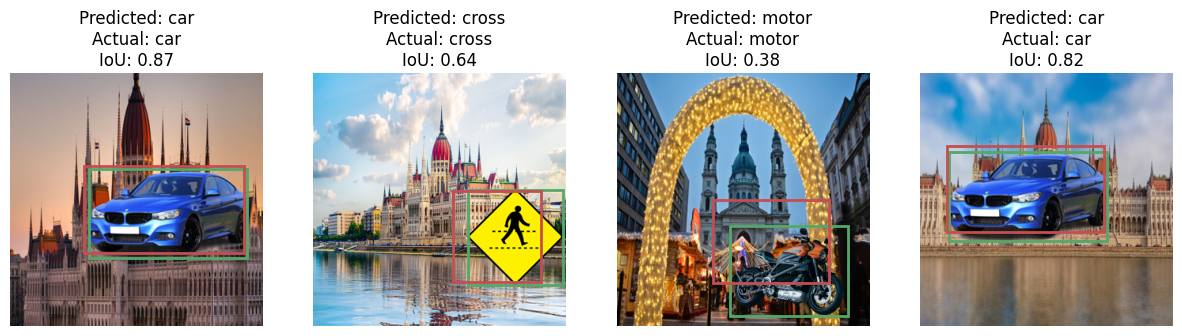

YOLO Model Prediction


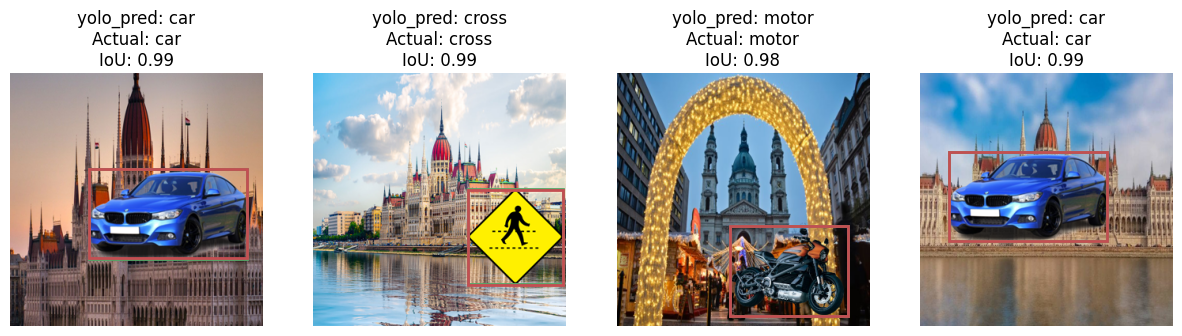

In [167]:
# do yolo model only detection for image 

def yolo_detection(yolo_model, test_dataset ,rand):
    yolo_model = YOLO('runs/detect/train/weights/best.pt')
    # with torch.no_grad():
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 12))
    for i , ax in enumerate(axes.flatten()):
        org_img , category , bbox = test_dataset[rand+i]
        # org_img , category , bbox  = org_img.cpu().n , category.unsqueeze(0).to(device) , bbox.unsqueeze(0).to(device)
        org_img = org_img.cpu().numpy().transpose(1, 2, 0)
        category = category.cpu().numpy()
        bbox = bbox.cpu().numpy()

        
        image = test_dataset[rand+i][0].permute(1, 2, 0).numpy()*255
        image = Image.fromarray(image.astype(np.uint8))
       
        yolo_output = yolo_model.predict(image , verbose=False) 
        yolo_output = yolo_output[0].boxes
        for i , box in enumerate(yolo_output):
        
            x1, y1, width, height = box.xywh.cpu().numpy()[i]  
            iou = box.data.cpu().numpy()[i][4]
            label = box.data.cpu().numpy()[i][5]
            rectangle1 = patches.Rectangle((x1 -width/2, y1-height/2), width, height, linewidth=2, edgecolor='g', facecolor='none')
        
        # draw for the actual bbox
        # draw for the actual bbox
        x_center, y_center, width, height = bbox
        x_center = x_center * org_img.shape[0]
        y_center = y_center * org_img.shape[1]
        width = width * org_img.shape[0]
        height = height * org_img.shape[1]
        rectangle2 = patches.Rectangle((x_center - width/2 , y_center - height/2 ), width, height, linewidth=2, edgecolor='r', facecolor='none')
          
        

        ax.imshow(image)
        ax.add_patch(rectangle1)
        ax.add_patch(rectangle2)
        ax.axis('off')
        ax.set_title(f'yolo_pred: {object_class[int(label)]}' + '\n' 
                         + f'Actual: {object_class[category.item()]}'
                         + '\n' + f'IoU: {iou:.2f}')
    plt.show()
rand = np.random.randint(0, len(test_dataset)-4)
print("Custom Model Prediction")
cumstome_model_pred(model, test_dataset , rand)
print("YOLO Model Prediction")
yolo_detection(yolo_model, test_dataset , rand)



# 3. COMPARISON
**Compare the performance** of your custom model and the YOLO model, ensuring both are evaluated on the **same subset of images** for a fair comparison. Key metrics to include:

- **Precision**
- **Recall**
- **F1-Score**
- **IoU (Intersection over Union)**
- **mAP (mean Average Precision)**

### Visualize Predictions

- Show predictions from both models on the same images.
- Include bounding boxes, class labels, and relevant metrics like IoU or Precision.

### Explain Differences

- Discuss why one model may perform better than the other, considering architecture, dataset complexity, or fine-tuning.

### Improve Custom Model

- Suggest improvements such as better data augmentation, model architecture adjustments, hyperparameter tuning, or more training data.
- Explore **Transfer Learning**, **learning rate scheduling**, or new optimizers for better performance.


# Object Detection: YOLOv8 vs. Custom Model
## Key Differences
### 1. Architecture Design
- **yolo8**: Features an optimized, multi-scale architecture for efficient feature extraction and handling diverse objects.
- **custom model**: custom model  has a more straightforward architecture. It consists of a basic convolutional backbone and simple fully connected layers for classification and bounding box regression.While simpler, it may lack the ability to extract complex features from images as effectively as YOLOv8, which is designed for high performance and speed.
### 2. Speed & Efficiency
- **yolo8** Designed for real-time performance, offering faster processing and lower latency.
- **custom model **: May be slower and less efficient, making it less suitable for real-time applications.
### 3. Generalization
- **yolo8**: Pre-trained on large datasets, enabling it to adapt well to new tasks with less data.
- **custom model**: Requires more data and extensive training to achieve similar levels of generalization.
### 4. Ease of Fine-Tuning
- **yolo8**: Streamlined for fine-tuning and customization, making it versatile across various use cases.
- **custome model**: May need more manual effort to optimize, with less flexibility in adapting to new tasks.

## References
- [YOLOv8 Documentation](https://github.com/ultralytics/ultralytics)
- [Object Detection Fundamentals](https://en.wikipedia.org/wiki/Object_detection)

YOLOv8  perform better due to its advanced architecture, optimized feature extraction, multi-scale detection capabilities, and extensive pre-training on large datasets. This custom model is simpler and might serve well for less complex tasks or as a learning tool but would struggle to match the performance and efficiency of YOLOv8 in real-world scenarios.

mAP of yolo is higer than custome model as shown in the bar graph at different level.

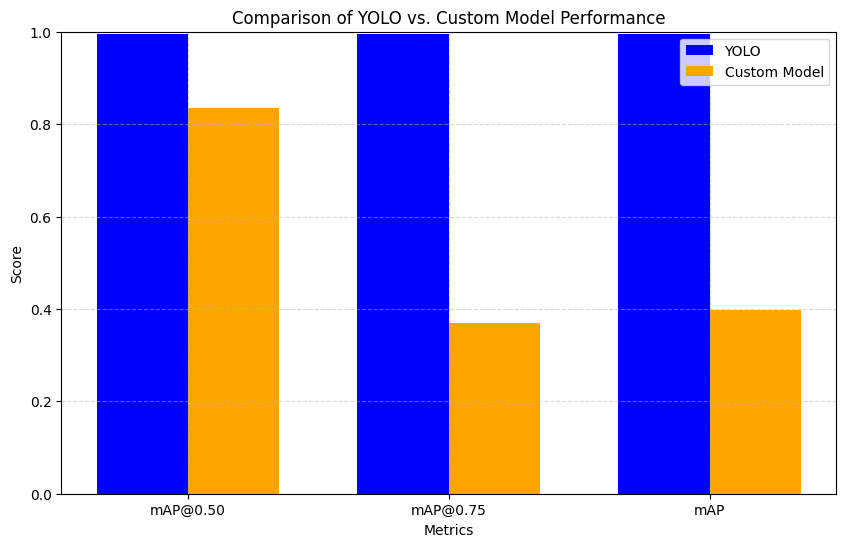

In [34]:
def compare_models():
    # Evaluate both model
    metrics = ['mAP@0.50', 'mAP@0.75', 'mAP']
    yolo_values = [yolo_map_50, yolo_map_75 ,yolo_map]
    custom_values = [custome_map_50, custome_map_75, custome_map]

    plot_comparison(metrics, yolo_values, custom_values)

def plot_comparison(metrics, yolo_values, custom_values):
    x = range(len(metrics))
    
    # Create a grouped bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    
    # Plot bars for YOLO and custom model
    ax.bar([p - width/2 for p in x], yolo_values, width, label='YOLO', color='blue')
    ax.bar([p + width/2 for p in x], custom_values, width, label='Custom Model', color='orange')

    # Set labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Comparison of YOLO vs. Custom Model Performance')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)  # Assuming mAP values range from 0 to 1
    ax.legend()

    # Display the plot
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
compare_models()


# Model Improvement 
1. Data Agumentation : The data we use is simply paste the object at specific position. we can add techniques like random cropping, flipping, rotation, color jittering, and scaling to make the model more robust to variations and improve generalization.

2. More trainining data : Use a larger or more diverse dataset to improve the model’s ability to generalize across different scenarios, especially if it struggles with variability.

3. Model Arcitecture : I use one convoultional layer before maxpooling ,, we can add more conveltional layer before maxpooling this can improve the feature extrction while adding the number of parametrs to learn .

4. Hyperparameter Tuning : I have already expriemnt with different batch size and learning rate , drope out rates.but we can still make more Experiment with different learning rates, batch sizes, and dropout rates to find the best configuration for training stability and accuracy.

5. Transfer Learning : Use a pre-trained backbone (e.g.,VGG16 , ResNet, MobileNet) to initialize the model. This allows the model to leverage pre-learned features, reducing the need for large datasets.But this increases the number of parametrs to learn increase the trainning rate and needs more computitional resourse.

#### We can use vgg16 model for object detection  by loading vgg16 pretrained model a backbone and customize the fully connected layer according to our image and num_classes.  

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomVGG16ObjectDetectionModel640(nn.Module):
    def __init__(self, num_classes):
        super(CustomVGG16ObjectDetectionModel640, self).__init__()
        
        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        
        # Use the features part of VGG16 as the backbone
        self.backbone = vgg16.features
        
        # Freeze the backbone to prevent training it
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Adjusted fully connected layers for 640x640 input
        self.shared_fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 20 * 20, 4096),  # Adjusted input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # Classification branch
        self.classification = nn.Linear(1024, num_classes)
        
        # Bounding box regression branch
        self.bbox_regression = nn.Linear(1024, 4)
        
    def forward(self, x):
        # Pass the input through the backbone (VGG16 feature extractor)
        x = self.backbone(x)
        
        # Pass the flattened output through shared fully connected layers
        x = self.shared_fc(x)
        
        # Class Prediction Branch
        classification_out = self.classification(x)
        
        # Bounding Box Regression Branch
        bbox_out = self.bbox_regression(x)
        
        return classification_out, bbox_out

# Example usage
num_classes = 3  # Adjust this as per your dataset
model = CustomVGG16ObjectDetectionModel640(num_classes)

# Sample input (batch_size=1, channels=3, height=640, width=640)
sample_input = torch.randn(1, 3, 640, 640)
classification_out, bbox_out = model(sample_input)

print("Classification Output:", classification_out)
print("Bounding Box Output:", bbox_out)
